In [1]:
import sys
import paddle
sys.path.append("./work")

#PLACE = paddle.CUDAPlace(0)
# print(paddle.device.get_device())
#paddle.device.set_device('gpu:0')

In [2]:
from model import LatentModulatedSiren # 这个就是我们的模型F_theta
from utils import get_coordinate_grid
from paddle.vision.models import resnet34
from dataloaders import create_dataloader

In [3]:
from paddle.vision import transforms
import dataloaders.mnist as mnist
import paddle
def test_dataloader(dset, dset_root=None, batch_size=8):
    """Create dataloader for selected dataset"""
    if dset == "mnist":
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        dataset = mnist.Mnist(split='test',transforms=transform)
    elif dset == "cifar10":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        dataset = mnist.Cifar(split='test',transforms=transform)
    # Other options...

    dataloader = paddle.io.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=2,
    )

    return dataloader

In [4]:
model_cfg = {
    'batch_size': 16,
    'out_channels': 3, # RGB
    'depth': 15,
    'latent_dim': 1024,
    'latent_init_scale': 0.01,
    'layer_sizes': [],
    'meta_sgd_clip_range': [0, 1],
    'meta_sgd_init_range': [0.005, 0.1],
    'modulate_scale': False,
    'modulate_shift': True,
    'use_meta_sgd': True,
    'w0': 30,
    'width': 1024}

model = LatentModulatedSiren(**model_cfg)
model.set_state_dict(paddle.load("/home/aistudio/output/cifar10_1024_bs16_noaug_noaug.pdparams"))
# modulate = model.latent.latent_vector.detach() # detach

In [5]:
classifier=resnet34(pretrained=True)
classifier.fc = paddle.nn.Linear(512, 10) 
dataloader_test=test_dataloader(dset='cifar10',batch_size=16)
#dataloader_train=create_dataloader.create_dataloader(dset='cifar10', batch_size=16)

shape of X: (10000, 3, 32, 32), y: (10000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


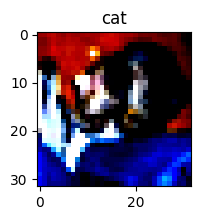

In [19]:
import matplotlib.pyplot as plt
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
for batch_data in dataloader_test:
    img,_,labels,_=batch_data
    img=img[0]
    # print(img)
    plt.figure(figsize=(2,2))
    plt.title(classes[labels[0]])
    plt.imshow(img)
    break

In [6]:
import paddle.nn as nn
def inner_loop(images, coords, network, optim, 
                criterion=nn.MSELoss(reduction='none'), modulate=None, meta_sgd=False):
    best_loss=1e7
    best_recon=None
    network.train()
    for i in range(5):
        #network.clear_gradients()
        recon = network(coords, modulate)

        loss = criterion(recon, images) # N, H, W, C
        loss = loss.mean([1, 2, 3]).sum(0)
        # print(i)
        loss.backward()
        
        optim.step()
        optim.clear_grad()
        if best_loss>loss[0]:
            best_loss=loss[0]
            best_recon=recon
    
    return best_loss,best_recon

In [12]:
import numpy as np
import matplotlib.pyplot as plt
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
model.train()
optim=paddle.optimizer.SGD(1e-2,parameters=[model.latent.latent_vector])
criterion = paddle.nn.MSELoss(reduction='none')
total_loss=0
plt.figure(figsize=(8, 4))
for i,batch_data in enumerate(dataloader_test):
    imgs, coords, labels, idxs = batch_data
    
    paddle.assign(
    np.zeros(model.latent.latent_vector.shape).astype("float32"),
    model.latent.latent_vector)
    loss,recon=inner_loop(imgs,coords,model,optim,criterion)
    total_loss+=loss
    if i==0:
        for j in range(4):
            plt.subplot(2,4, j * 2 + 1)
            # print(images[j])
            plt.imshow(imgs[j].numpy())
            plt.axis("off")
            plt.title("Source: {}".format(classes[labels[j]]))
            #print(pp_out[j])
            plt.subplot(2, 4, j * 2 + 2)
            plt.imshow(recon[j].numpy())
            plt.axis("off")
            plt.title("Generated")
        print('total loss: {:.3f}, PSNR: {:.3f}'.format(total_loss.numpy()[0],-10 * np.log10(total_loss.numpy() /model_cfg['batch_size'])[0]))  #lenth of test dataset

print('total loss: {:.3f}, PSNR: {:.3f}'.format(total_loss.numpy()[0],-10 * np.log10(total_loss.numpy() /10000)[0]))  #lenth of test dataset


total loss: 2.048, PSNR: 8.928


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss: Tensor(shape=[1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [2.63727069])


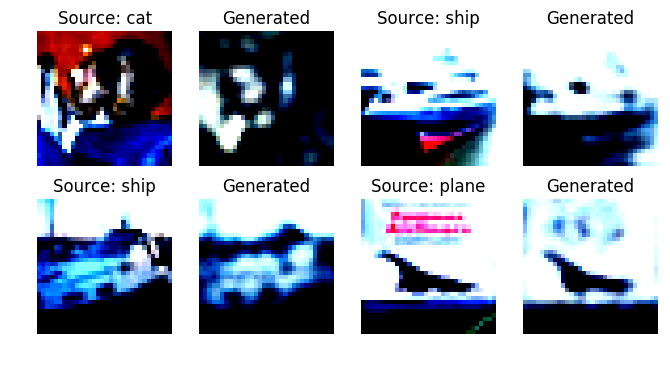

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
total_loss=0
optim=paddle.optimizer.SGD(1e-2,parameters=[model.latent.latent_vector])
for i,batch_data in enumerate(dataloader_test):
    imgs, coords, labels, idxs = batch_data
    paddle.assign(
    np.zeros(model.latent.latent_vector.shape).astype("float32"),
    model.latent.latent_vector)
    loss,recon=inner_loop(imgs,coords,model,optim,criterion)
    total_loss+=loss
    if i==0:
        for j in range(4):
            plt.subplot(2,4, j * 2 + 1)
            # print(images[j])
            plt.imshow(imgs[j].numpy())
            plt.axis("off")
            plt.title("Source: {}".format(classes[labels[j]]))
            #print(pp_out[j])
            plt.subplot(2, 4, j * 2 + 2)
            plt.imshow(recon[j].numpy())
            plt.axis("off")
            plt.title("Generated")
        print('loss:',total_loss)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


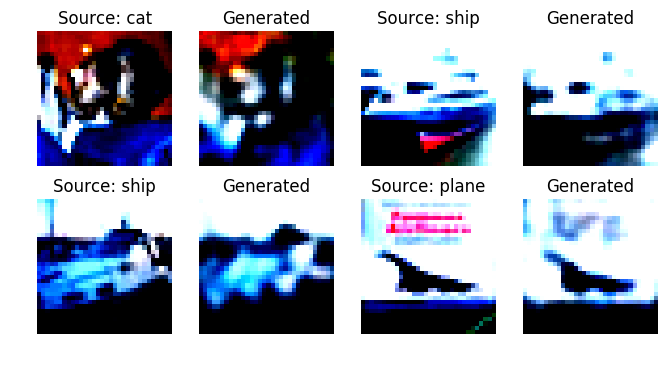

In [8]:
plt.figure(figsize=(8, 4))
total_loss=0
optim=paddle.optimizer.SGD(1e-2,parameters=[model.latent.latent_vector])
for i,batch_data in enumerate(dataloader_test):
    imgs, coords, labels, idxs = batch_data
    paddle.assign(
    np.zeros(model.latent.latent_vector.shape).astype("float32"),
    model.latent.latent_vector)
    loss,recon=inner_loop(imgs,coords,model,optim,criterion)
    total_loss+=loss
    if i==0:
        for j in range(4):
            plt.subplot(2,4, j * 2 + 1)
            # print(images[j])
            plt.imshow(imgs[j].numpy())
            plt.axis("off")
            plt.title("Source: {}".format(classes[labels[j]]))
            #print(pp_out[j])
            plt.subplot(2, 4, j * 2 + 2)
            plt.imshow(recon[j].numpy())
            plt.axis("off")
            plt.title("Generated")
        print('loss:',total_loss)
        break


In [22]:
from paddle.metric import Accuracy
import numpy as np
import os
def cross_validation(model, classifier, dataloader, metric):
    classifier.eval()
    metric.reset()
    inner_optim=paddle.optimizer.SGD(3e-3,parameters=[model.latent.latent_vector])
    inner_criterion = paddle.nn.MSELoss(reduction='none')
    for batch_data in dataloader:
        imgs, coords, labels, idxs = batch_data
        paddle.assign(
            np.zeros(model.latent.latent_vector.shape).astype("float32"),
            model.latent.latent_vector)
        _, features = inner_loop(imgs,coords,model,inner_optim,inner_criterion)
        features=features.transpose((0,3,1,2))
        inner_optim.clear_grad()
        with paddle.no_grad():
            outputs = classifier(features)
            metric.update(metric.compute(outputs, labels))
    
    accuracy = metric.accumulate()
    return accuracy

def train(lr, model, classifier, train_dataloader, test_dataloader, num_epochs):
    best_acc=0
    criterion = paddle.nn.CrossEntropyLoss()
    optimizer = paddle.optimizer.Adam(lr,parameters=classifier.parameters(),weight_decay=1e-4)
    inner_optim=paddle.optimizer.SGD(3e-3,parameters=[model.latent.latent_vector])
    inner_criterion = paddle.nn.MSELoss(reduction='none')
    metric = Accuracy()
    # modulate = model.latent.latent_vector.detach()
    for epoch in range(num_epochs):
        classifier.train()
        for iter, batch_data in enumerate(train_dataloader):
            imgs, coords, labels, idxs = batch_data
            # print(imgs.shape,modulate.shape)
            paddle.assign(
            np.zeros(model.latent.latent_vector.shape).astype("float32"),
            model.latent.latent_vector)
            inner_loss, features = inner_loop(imgs,coords,model,inner_optim,inner_criterion)
            inner_optim.clear_grad()
            classifier.clear_gradients()
            # print(inner_loss)
            features=features.transpose([0,3,1,2])
            features_2=features.detach()
            features.stop_gradient=True   #停止梯度计算！！！！
            features_2.stop_gradient=False
            outputs = classifier(features_2)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.clear_grad()
            if iter%500==0:
                print("Epoch [{}/{}], Iter: {}, loss: {}".format(epoch+1,num_epochs,iter,loss.item()))
        
        accuracy = cross_validation(model, classifier, test_dataloader, metric)
        print("Epoch [{}/{}], Accuracy: {}".format(epoch+1,num_epochs,accuracy))
        if best_acc<accuracy:
            paddle.save(classifier.state_dict(), os.path.join("./output/", 'resnet34.pdparams'))

In [11]:
classifier.set_state_dict(paddle.load('/home/aistudio/output/resnet34.pdparams'))
train(1e-4, model, classifier, dataloader_train, dataloader_test, 9)

Epoch [1/9], Iter: 0, loss: 1.6962661743164062
Epoch [1/9], Iter: 500, loss: 1.4408173561096191
Epoch [1/9], Iter: 1000, loss: 1.5790090560913985
Epoch [1/9], Iter: 1500, loss: 1.4931330680847168
Epoch [1/9], Iter: 2000, loss: 1.6405186653137207
Epoch [1/9], Iter: 2500, loss: 1.6614797115325928
Epoch [1/9], Iter: 3000, loss: 1.6700186729431152
Epoch [1/9], Accuracy: 0.5165


In [16]:
paddle.device.cuda.empty_cache()

In [5]:
model_cfg = {
    'batch_size': 16,
    'out_channels': 1, # Gray
    'depth': 15,
    'latent_dim': 512,
    'latent_init_scale': 0.01,
    'layer_sizes': [],
    'meta_sgd_clip_range': [0, 1],
    'meta_sgd_init_range': [0.005, 0.1],
    'modulate_scale': False,
    'modulate_shift': True,
    'use_meta_sgd': True,
    'w0': 30,
    'width': 512}

In [6]:
model_mnist = LatentModulatedSiren(**model_cfg)
state_dict = paddle.load("./work/assets/mnist_params_512_latents_100000.pdparams")
model_mnist.set_state_dict(state_dict)

W0617 13:47:23.578294 21874 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0617 13:47:23.582486 21874 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1492: UserWarning: Skip loading for meta_sgd_lrs.meta_sgd_lrs. meta_sgd_lrs.meta_sgd_lrs is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1492: UserWarning: Skip loading for latent.latent_vector. latent.latent_vector receives a shape [128, 512], but the expected shape is [16, 512].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))


In [7]:
dataloader_test_mnist=test_dataloader(dset='mnist',batch_size=16)
dataloader_train_mnist=create_dataloader.create_dataloader(dset='mnist',batch_size=16)

shape of X: (10000, 32, 32), y: (10000,)
shape of X: (60000, 32, 32), y: (60000,)


In [8]:
import paddle
import paddle.nn.functional as F
class LeNet(paddle.nn.Layer):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = paddle.nn.Conv2D(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.max_pool1 = paddle.nn.MaxPool2D(kernel_size=2,  stride=2)
        self.conv2 = paddle.nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.max_pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=576, out_features=120)
        self.linear2 = paddle.nn.Linear(in_features=120, out_features=84)
        self.linear3 = paddle.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.flatten(x, start_axis=1,stop_axis=-1)
        # print(x.shape)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x


classifier=LeNet()

In [10]:
criterion = paddle.nn.MSELoss('none') # 自定义逻辑，重建结果样本内mean，样本间sum
inner_optim = paddle.optimizer.SGD(1e-2, parameters=[model_mnist.latent.latent_vector]) # 内圈优化只调整phi

In [12]:
import numpy as np

def train_mnist(lr, model, classifier, train_dataloader, test_dataloader, num_epochs):
    criterion = paddle.nn.CrossEntropyLoss()
    optimizer = paddle.optimizer.Adam(lr,parameters=classifier.parameters())
    inner_optim=paddle.optimizer.SGD(1e-2,parameters=[model.latent.latent_vector])
    inner_criterion = paddle.nn.MSELoss(reduction='none')
    metric = Accuracy()
    # modulate = model.latent.latent_vector.detach()
    for epoch in range(num_epochs):
        classifier.train()
        for i,batch_data in enumerate(train_dataloader):
            #print(i)
            paddle.assign(
            np.zeros(model.latent.latent_vector.shape).astype("float32"),
            model.latent.latent_vector,
        )
            optimizer.clear_grad()
            # classifier.clear_gradients()
            imgs, coords, labels, idxs = batch_data
            # print(imgs.shape,modulate.shape)
            #imgs=imgs.transpose((0,2,3,1))
            _, features = inner_loop(imgs,coords,model,inner_optim,inner_criterion)
            features_2=features.transpose((0,3,1,2))
            features_2.stop_gradient=True
            outputs = classifier(features_2)
            outer_loss = criterion(outputs, labels)
            
            outer_loss.backward()
            optimizer.step()
        
        accuracy = cross_validation(model, classifier, test_dataloader, metric)
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}")

In [ ]:
train_mnist(1e-3,model_mnist,classifier,dataloader_train_mnist,dataloader_test_mnist,5)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

model_mnist.train()
total_loss=0
plt.figure(figsize=(15, 8))
for i,batch_data in enumerate(dataloader_test_mnist):
    imgs, coords, labels, idxs = batch_data
    imgs=imgs.transpose((0,2,3,1))
    paddle.assign(
    np.zeros(model_mnist.latent.latent_vector.shape).astype("float32"),
    model_mnist.latent.latent_vector)
    loss,recon=inner_loop(imgs,coords,model_mnist,inner_optim,criterion)
    total_loss+=loss
    if i==1:
        for j in range(4):
            plt.subplot(2,4, j * 2 + 1)
            # print(imgs[j])
            plt.imshow(imgs[j,...,0].numpy())
            plt.axis("off")
            plt.title("Source")
            # print(recon[j])
            plt.subplot(2, 4, j * 2 + 2)
            plt.imshow(recon[j,...,0].numpy())
            plt.axis("off")
            plt.title("Generated")
        print('total loss: {:.6f}, PSNR: {:.6f}'.format(total_loss.numpy()[0],-10 * np.log10(total_loss.numpy() /model_cfg['batch_size'])[0]))  #lenth of test dataset

print('total loss: {:.6f}, PSNR: {:.6f}'.format(total_loss.numpy()[0],-10 * np.log10(total_loss.numpy() /10000)[0]))  #lenth of test dataset


In [14]:
from paddle.vision.datasets import Cifar10
import paddle.vision.transforms as T

transform=T.ToTensor()
cifar10 = Cifar10(mode='test')

for i in range(5):  # only show first 5 images
    img, label = cifar10[i]
    # do something with img and label
    print(transform(img))
    # <class 'PIL.Image.Image'> (32, 32) 6

Tensor(shape=[3, 32, 32], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[[0.61960787, 0.62352943, 0.64705884, ..., 0.53725493,
          0.49411768, 0.45490199],
         [0.59607846, 0.59215689, 0.62352943, ..., 0.53333336,
          0.49019611, 0.46666670],
         [0.59215689, 0.59215689, 0.61960787, ..., 0.54509807,
          0.50980395, 0.47058827],
         ...,
         [0.26666668, 0.16470589, 0.12156864, ..., 0.14901961,
          0.05098040, 0.15686275],
         [0.23921570, 0.19215688, 0.13725491, ..., 0.10196079,
          0.11372550, 0.07843138],
         [0.21176472, 0.21960786, 0.17647059, ..., 0.09411766,
          0.13333334, 0.08235294]],

        [[0.43921572, 0.43529415, 0.45490199, ..., 0.37254903,
          0.35686275, 0.33333334],
         [0.43921572, 0.43137258, 0.44705886, ..., 0.37254903,
          0.35686275, 0.34509805],
         [0.43137258, 0.42745101, 0.43529415, ..., 0.38431376,
          0.37254903, 0.34901962],
         ...,
       